# Descripción del proyecto

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan y la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

# Contents <a id='back'></a>

* [Descripción de las tarifas](#intro)
* [Etapa 1. Descripción de los datos](#data_review)
    * [Conclusions](#data_review_conclusions)
* [Etapa 2. Data preprocessing](#data_preprocessing)
    * [2.1 Cambiando tipos de datos](#header_style)
    * [2.2 Duplicados](#missing_values)
    * [2.3 Valores ausentes](#duplicates)
* [Etapa 3. Enriqueciendo los datos](#enriqueciendo)
    * [3.1 Agregando columnas](#columns)
    * [3.2 Detectando errores](#errors)
* [Etapa 4. Analizando la data](#analisis)
    * [4.1 Agrupando información](#group)
    * [4.2 Fusionando las tablas](#merging)
    * [4.3 Calculando el consumo](#calculating)
* [Etapa 5. Estudiando resultados](#results)
    * [5.1 Simplificando la data](#simplifiying)
    * [5.2 Valosres atípicos](#outliners)
    * [5.3 Encontrando minutos, SMS y volumen de datos para cada tarifa por mes](#find)
    * [5.4 Conclusiones](#conclusions)
* [Etapa 6. Prueba de hipótesis](#hypotheses)
* [Etapa 7. Conclusión General](#end)

# Descripción de las tarifas <a id='intro'></a>
**Nota**: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para **llamadas**, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para **tráfico web**, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

**Surf**
1. Pago mensual: 20$

2. 500 minutos al mes, 50 SMS y 15 GB de datos
3. Si se exceden los límites del paquete:
    - 1 minuto: 3 centavos
    - 1 SMS: 3 centavos
    - 1 GB de datos: 10$
    
**Ultimate**
1. Pago mensual: 70$

2. 3000 minutos al mes, 1000 SMS y 30 GB de datos
3. Si se exceden los límites del paquete:
    - 1 minuto: 1 centavo
    - 1 SMS: 1 centavo
    - 1 GB de datos: 7$
    
[Volver a Contenidos](#back)

# Etapa 1. Descripción de los datos <a id='data_review'></a>

La tabla `users` (datos sobre los usuarios):
- user_id — identificador único del usuario
- first_name — nombre del usuario
- last_name — apellido del usuario
- age — edad del usuario (en años)
- reg_date — fecha de suscripción (dd, mm, aa)
- churn_date — la fecha en que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron estos datos)
- city — ciudad de residencia del usuario
- plan — nombre de la tarifa

La tabla `calls` (datos sobre las llamadas):
- id — identificador único de la llamada
- call_date — fecha de la llamada
- duration — duración de la llamada (en minutos)
- user_id — el identificador del usuario que realiza la llamada

La tabla `messages` (datos sobre los SMS):
- id — identificador único del SMS
- message_date — fecha del SMS
- user_id — el identificador del usuario que manda el SMS

La tabla `internet` (datos sobre las sesiones web):
- id — identificador único de la sesión
- mb_used — el volumen de datos gastados durante la sesión (en megabytes)
- session_date — fecha de la sesión web
- user_id — identificador del usuario

La tabla `plans` (datos sobre las tarifas):
- plan_name — nombre de la tarifa
- usd_monthly_fee — pago mensual en dólares estadounidenses
- minutes_included — minutos incluidos al mes
- messages_included — SMS incluidos al mes
- mb_per_month_included — datos incluidos al mes (en megabytes)
- usd_per_minute — precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos el operador cobrará el minuto 101)
- usd_per_message — precio por SMS tras exceder los límites del paquete
- usd_per_gb — precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes)

[Volver a Contenidos](#back)

Vamos a abrir los archivos de datos y estudiar la información general

In [1]:
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

In [3]:
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


In [4]:
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


In [5]:
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


En estas primeras tres tablas, podemos ver que hay muchos mensajes, llamadas y sesiones de datos que se llevan a cabo en el mismo mes, incluso en el mismo día. Considerando esto, sería conveniente agruparlas por mes para tener los datos mejor ordenados. Veamos las tablas plans y users.

In [6]:
plans.info()
plans.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
users.info()
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


En estas dos tablas tenemos información muy importante acerca del cada usuario y el detalle del plan que usa, lo que nos servirá para calcular la información que necesitaremos al momento de estudiar nuestras hipótesis.

[Volver a Contenidos](#back)

# Etapa 2. Data preprocessing

# 2.1 Cambiando tipos de datos
Vamos ahora con la preparación de los datos. Lo primero que haremos setá convertir los datos en los tipos necesarios. Podemos observar que en todas las tablas, a excepción de `plans`, hay columnas de fecha cuyo tipo de dato es object. Vamos a convertirlos al tipo datetime.

In [8]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format='%Y-%m-%d')

internet["session_date"] = pd.to_datetime(internet["session_date"], format='%Y-%m-%d')

messages["message_date"] = pd.to_datetime(messages["message_date"], format='%Y-%m-%d')

users["reg_date"] = pd.to_datetime(users["reg_date"], format='%Y-%m-%d')

users["churn_date"] = pd.to_datetime(users["churn_date"], format='%Y-%m-%d')

print(calls["call_date"].head())
print(internet["session_date"].head())
print(messages["message_date"].head())
print(users["reg_date"].head())
print(users["churn_date"].head())

0   2018-12-27
1   2018-12-27
2   2018-12-27
3   2018-12-28
4   2018-12-30
Name: call_date, dtype: datetime64[ns]
0   2018-12-29
1   2018-12-31
2   2018-12-28
3   2018-12-26
4   2018-12-27
Name: session_date, dtype: datetime64[ns]
0   2018-12-27
1   2018-12-31
2   2018-12-31
3   2018-12-27
4   2018-12-26
Name: message_date, dtype: datetime64[ns]
0   2018-12-24
1   2018-08-13
2   2018-10-21
3   2018-01-28
4   2018-05-23
Name: reg_date, dtype: datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: churn_date, dtype: datetime64[ns]


# 2.2 Duplicados
Revisemos las tablas en busca de valores duplicados

In [9]:
print(calls.duplicated().sum())
print(internet.duplicated().sum())
print(messages.duplicated().sum())
print(users.duplicated().sum())

0
0
0
0


# 2.3 Valores ausentes
Vemos que, de todas las tablas, la única con valores ausentes es users en la columna churn_date. Sabemos por la información suministrada que si el valor de esta variable es ausente, la tarifa se estaba usando cuando se recuperaron estos datos, lo que quiere decir que el usuario esta activo. Por lo tanto, vamos a conservar esos valores conociendo lo mencionado.

[Volver a Contenidos](#back)

# Etapa 3. Enriqueciendo los datos

# 3.1 Agregando columnas
Ahora que no tenemos valores ausentes, duplicados y que corregimos el tipo de datos, agreguemos columnas relevantes para nuestra investigación

In [10]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

print(calls.head())
print(internet.head())
print(messages.head())

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27      8.52     12
1  1000_145     1000 2018-12-27     13.66     12
2  1000_247     1000 2018-12-27     14.48     12
3  1000_309     1000 2018-12-28      5.76     12
4  1000_380     1000 2018-12-30      4.22     12
         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-29    89.86     12
1  1000_204     1000   2018-12-31     0.00     12
2  1000_379     1000   2018-12-28   660.40     12
3  1000_413     1000   2018-12-26   270.99     12
4  1000_442     1000   2018-12-27   880.22     12
         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12


# 3.2 detectando errores
busquemos y eliminemos posibles errores en los datos. Comencemos por la tabla de llamadas.

In [11]:
calls['duration'].value_counts().sort_index()

0.00     26834
0.01        51
0.02        51
0.03        56
0.04        46
         ...  
35.35        1
35.74        1
35.88        1
36.24        1
37.60        1
Name: duration, Length: 2802, dtype: int64

Vemos una cantidad grande de llamadas con una duración de 0.0 minutos. Veamos que porcentaje de las llamadas totales representan

In [12]:
total_calls = 137735
missing_calls = 26834

missing_calls_rate = missing_calls / total_calls

f"El porcentaje de llamadas perdidas es: {missing_calls_rate:.0%}"

'El porcentaje de llamadas perdidas es: 19%'

Las llamadas de 0.0 segundos representan el 19% del total de llamadas. Es un porcentaje importante, por lo que haremos una tabla filtrada sin estas llamadas para compararlo con el DataFrame completo.

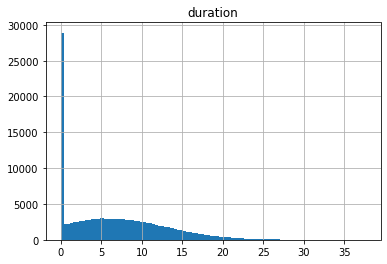

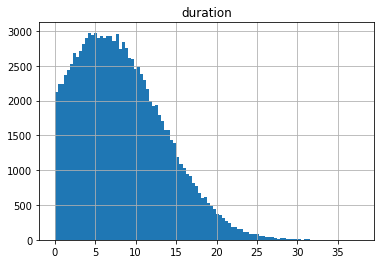

In [13]:
calls_filtered = calls.query('duration >= 0.01')
calls.hist('duration', bins=100)
plt.show()
calls_filtered.hist('duration', bins=100)
plt.show()

Si bien es un porcentaje importante, definitivamente es un valor atípico que probablemente se debe a llamadas perdidas, es decir, que la persona a quien se llamó nunca contestó. No las eliminaremos, ya que, si bien no representan ningún gasto a los minutos del plan ni ningún cobro adicional al cliente, estos deben pagar una tarifa base aunque no consuman minutos.

Revisemos ahora la tabla de internet.

In [14]:
internet['mb_used'].value_counts().sort_index()

0.00       13747
0.01           1
0.02           2
0.03           1
0.04           2
           ...  
1604.46        1
1634.39        1
1636.47        1
1668.03        1
1693.47        1
Name: mb_used, Length: 57624, dtype: int64

De forma similar que con las llamadas, vemos una cantidad grande de sesiones con un consumo de 0.0 MB. Veamos que porcentaje de las sesiones totales representan

In [15]:
total_sesions = 104825
missing_sesions = 13747

missing_sesions_rate = missing_sesions / total_sesions

f"El porcentaje de sesiones perdidas es: {missing_sesions_rate:.0%}"

'El porcentaje de sesiones perdidas es: 13%'

Las sesiones de 0.0 MB representan el 13% del total de sesiones. Es un porcentaje importante, por lo que, al igual que como hicimos con las llamadas, haremos una tabla filtrada sin estas sesiones para compararlo con el DataFrame completo.

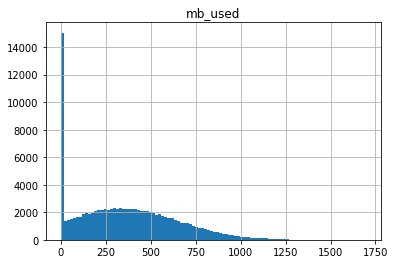

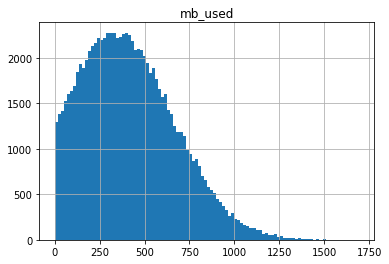

In [16]:
sesions_filtered = internet.query('mb_used >= 0.01')
internet.hist('mb_used', bins=100)
plt.show()
sesions_filtered.hist('mb_used', bins=100)
plt.show()

Definitivamente es un valor atípico, que podemos atribuir a cuando estás conectado a una red wifi o cuando se abre y se cierra el navegador rapidamente. No las eliminaremos, ya que, aunque no hayan consumido ni un solo MB del plan, estos clientes deben pagar una tarifa base, aunque no consuman sus MB.

[Volver a Contenidos](#back)

# Etapa 4. Analizando la data

# 4.1 agrupando información

Ahora que tenemos más ordenada nuestras tablas, vamos a buscar para cada usuario la siguiente informacion:
- El número de llamadas realizadas y minutos utilizados al mes
- La cantidad de los SMS enviados por mes.
- El volumen de datos por mes.
- Los ingresos mensuales de cada usuario (resta el límite del paquete gratuito del número total de llamadas, SMS y datos; multiplica el resultado por el valor de tarifa de llamadas; agrega el cargo mensual según la tarifa de llamadas)

In [17]:
# Minutos usados al mes
total_min = calls.pivot_table(
    index=["user_id", "month"],
    values="duration",
    aggfunc="sum"
)
total_min = total_min.rename(columns={
    'duration': 'total_minutes'    
})

total_min

total_minutes
user_id month               
1000    12            116.83
1001    8             171.14
        9             297.69
        10            374.11
        11            404.59
...                      ...
1498    12            324.77
1499    9             330.37
        10            363.28
        11            288.56
        12            468.10

[2258 rows x 1 columns]

In [18]:
# Número de llamadas por usuario
total_calls = calls.pivot_table(
    index=["user_id", "month"],
    values="id",
    aggfunc="count"
)
total_calls = total_calls.rename(columns={
    'id': 'total_calls'    
})
total_calls

total_calls
user_id month             
1000    12              16
1001    8               27
        9               49
        10              65
        11              64
...                    ...
1498    12              39
1499    9               41
        10              53
        11              45
        12              65

[2258 rows x 1 columns]

In [19]:
# cantidad de los SMS enviados por mes
total_messages = calls.pivot_table(
    index=["user_id", "month"],
    values="id",
    aggfunc="count"
)
total_messages = total_messages.rename(columns={
    'id': 'total_messages'    
})
total_messages

total_messages
user_id month                
1000    12                 16
1001    8                  27
        9                  49
        10                 65
        11                 64
...                       ...
1498    12                 39
1499    9                  41
        10                 53
        11                 45
        12                 65

[2258 rows x 1 columns]

In [20]:
# volumen de datos por mes
total_gb = internet.pivot_table(
    index=["user_id", "month"],
    values="mb_used",
    aggfunc="sum"
)
total_gb = total_gb.rename(columns={
    'mb_used': 'total_gb'    
})
total_gb = np.ceil(total_gb / 1024)
total_gb

total_gb
user_id month          
1000    12          2.0
1001    8           7.0
        9          14.0
        10         22.0
        11         19.0
...                 ...
1498    12         23.0
1499    9          13.0
        10         20.0
        11         17.0
        12         22.0

[2277 rows x 1 columns]

Ahora, para conocer el ingreso adicional por mes de los usuarios, arreglemos un poco nuestras tablas. Lo primero que vamos a hacer es renombrar la columna plan_name de la tabla plans, para que el nombre coicida con el de la tabla users y así podamos fusionarlas con másfacilidad.

In [21]:
plans = plans.rename(columns={
    'plan_name': 'plan'    
})
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


# 4.2 Fusionando las tablas

Ahora, vamos a fusionar todas las tablas en una sola para encontrar los ingresos extra por plan. Comenzaremos por las tablas total_min, Total_messages y total_gb, conservando como índice user_id y month. Usaremos el método de pandas concat

In [22]:
merged_data = pd.concat([total_min, total_messages, total_gb], axis=1)

merged_data

total_minutes  total_messages  total_gb
user_id month                                         
1000    12            116.83            16.0       2.0
1001    8             171.14            27.0       7.0
        9             297.69            49.0      14.0
        10            374.11            65.0      22.0
        11            404.59            64.0      19.0
...                      ...             ...       ...
1498    12            324.77            39.0      23.0
1499    9             330.37            41.0      13.0
        10            363.28            53.0      20.0
        11            288.56            45.0      17.0
        12            468.10            65.0      22.0

[2292 rows x 3 columns]

In [23]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2292 entries, (1000, 12) to (1499, 12)
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_minutes   2258 non-null   float64
 1   total_messages  2258 non-null   float64
 2   total_gb        2277 non-null   float64
dtypes: float64(3)
memory usage: 80.9 KB


Vemos que, luego de la fusión, tenemos algunos valores nulos en las columnas total_minutes, total_messages y total_gb. que sabemos son de los clientes que no consumieron nada de sus minutos, mensajes o datos, por eso, vamos a sustituirlos por 0

In [24]:
columns_to_fill = ['total_minutes', 'total_messages', 'total_gb']
for column in columns_to_fill:
    merged_data[column] = merged_data[column].fillna(0)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2292 entries, (1000, 12) to (1499, 12)
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_minutes   2292 non-null   float64
 1   total_messages  2292 non-null   float64
 2   total_gb        2292 non-null   float64
dtypes: float64(3)
memory usage: 80.9 KB


Unimos ahora la tabla resultante con la tabla users, para vincular así la información agrupada por mes a cada usuario

In [25]:
merged_data = merged_data.join(users.set_index('user_id'), on='user_id')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2292 entries, (1000, 12) to (1499, 12)
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   total_minutes   2292 non-null   float64       
 1   total_messages  2292 non-null   float64       
 2   total_gb        2292 non-null   float64       
 3   first_name      2292 non-null   object        
 4   last_name       2292 non-null   object        
 5   age             2292 non-null   int64         
 6   city            2292 non-null   object        
 7   reg_date        2292 non-null   datetime64[ns]
 8   plan            2292 non-null   object        
 9   churn_date      158 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 206.3+ KB


In [26]:
# merged_data = merged_data.merge(users.set_index('user_id'), on='user_id', how='outer')
# merged_data.info()

Por último, uniremos nuestra nueva tabla con la tabla plans, para así poder calcular los ingresos adcionales de cada usuario restando el límite del plan del número total de llamadas, SMS y datos. Ese resultado, lo multiplicaremos por el valor de tarifa de llamadas mensajes y datos adicionales.

In [27]:
merged_data = merged_data.join(plans.set_index('plan'), on='plan', how='outer')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2292 entries, (1000, 12) to (1499, 12)
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_minutes          2292 non-null   float64       
 1   total_messages         2292 non-null   float64       
 2   total_gb               2292 non-null   float64       
 3   first_name             2292 non-null   object        
 4   last_name              2292 non-null   object        
 5   age                    2292 non-null   int64         
 6   city                   2292 non-null   object        
 7   reg_date               2292 non-null   datetime64[ns]
 8   plan                   2292 non-null   object        
 9   churn_date             158 non-null    datetime64[ns]
 10  messages_included      2292 non-null   int64         
 11  mb_per_month_included  2292 non-null   int64         
 12  minutes_included       2292 non-null   int64   

In [28]:
# merged_data = merged_data.merge(plans.set_index('plan'), on='plan', how='outer')
# merged_data.info()

# 4.3 Calculando el consumo

Calculemos el consumo adicional por usuario, restando el límite del plan al número total de llamadas, SMS y datos de cada usuario, para identificar a los que exceden lo que incluye su plan. El resultado lo agregaremos en las nuevas columnas calls_income, messages_income y gb_income

In [29]:
merged_data['minutes_extra'] = merged_data['total_minutes'] - merged_data['minutes_included']
merged_data['messages_extra'] = merged_data['total_messages'] - merged_data['messages_included']
merged_data['gb_extra'] = merged_data['total_gb'] - (merged_data['mb_per_month_included'] / 1024)

merged_data.head()

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   

                   plan churn_date  messages_included  mb_per_month_included  \
user_id month                                                                  
1000    12     ultimate        NaT               1000                  30720   
1006    11     ultimate 2018-12-18               1000                  30720   
        12     ultimate 2018-12-18               1000                  30720   
1008    10     ultimate        NaT               1000                  30720   
        11     ultimate        NaT               1000                  30720   

               minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                                   
1000    12                 3000               70           7             0.01   
1006    11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1008    10                 3000               70           7             0.01   
        11                 3000               70           7             0.01   

               usd_per_minute  minutes_extra  messages_extra  gb_extra  
user_id month                                                           
1000    12               0.01       -2883.17          -984.0     -28.0  
1006    11               0.01       -2990.68          -998.0     -27.0  
        12               0.01       -2945.21          -991.0       2.0  
1008    10               0.01       -2549.79          -929.0     -13.0  
        11               0.01       -2577.19          -937.0      -6.0

Arreglemos los valores negativos

In [30]:
def fix__minutes_extra(row):
    minutes_extra = row['minutes_extra']    

    if minutes_extra < 0:
        return 0
    return minutes_extra

merged_data['minutes_extra'] = merged_data.apply(fix__minutes_extra, axis=1)

merged_data.head()

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   

                   plan churn_date  messages_included  mb_per_month_included  \
user_id month                                                                  
1000    12     ultimate        NaT               1000                  30720   
1006    11     ultimate 2018-12-18               1000                  30720   
        12     ultimate 2018-12-18               1000                  30720   
1008    10     ultimate        NaT               1000                  30720   
        11     ultimate        NaT               1000                  30720   

               minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                                   
1000    12                 3000               70           7             0.01   
1006    11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1008    10                 3000               70           7             0.01   
        11                 3000               70           7             0.01   

               usd_per_minute  minutes_extra  messages_extra  gb_extra  
user_id month                                                           
1000    12               0.01            0.0          -984.0     -28.0  
1006    11               0.01            0.0          -998.0     -27.0  
        12               0.01            0.0          -991.0       2.0  
1008    10               0.01            0.0          -929.0     -13.0  
        11               0.01            0.0          -937.0      -6.0

In [31]:
def fix_messages_extra(row):
    messages_extra = row['messages_extra']

    if messages_extra < 0:
        return 0
    return messages_extra


merged_data['messages_extra'] = merged_data.apply(fix_messages_extra, axis=1)

merged_data.head()

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   

                   plan churn_date  messages_included  mb_per_month_included  \
user_id month                                                                  
1000    12     ultimate        NaT               1000                  30720   
1006    11     ultimate 2018-12-18               1000                  30720   
        12     ultimate 2018-12-18               1000                  30720   
1008    10     ultimate        NaT               1000                  30720   
        11     ultimate        NaT               1000                  30720   

               minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                                   
1000    12                 3000               70           7             0.01   
1006    11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1008    10                 3000               70           7             0.01   
        11                 3000               70           7             0.01   

               usd_per_minute  minutes_extra  messages_extra  gb_extra  
user_id month                                                           
1000    12               0.01            0.0             0.0     -28.0  
1006    11               0.01            0.0             0.0     -27.0  
        12               0.01            0.0             0.0       2.0  
1008    10               0.01            0.0             0.0     -13.0  
        11               0.01            0.0             0.0      -6.0

In [32]:
def fix_gb_extra(row):
    gb_extra = row['gb_extra']

    if gb_extra < 0:
        return 0
    return gb_extra 


merged_data['gb_extra'] = merged_data.apply(fix_gb_extra, axis=1)

merged_data.head()

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   

                   plan churn_date  messages_included  mb_per_month_included  \
user_id month                                                                  
1000    12     ultimate        NaT               1000                  30720   
1006    11     ultimate 2018-12-18               1000                  30720   
        12     ultimate 2018-12-18               1000                  30720   
1008    10     ultimate        NaT               1000                  30720   
        11     ultimate        NaT               1000                  30720   

               minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                                   
1000    12                 3000               70           7             0.01   
1006    11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1008    10                 3000               70           7             0.01   
        11                 3000               70           7             0.01   

               usd_per_minute  minutes_extra  messages_extra  gb_extra  
user_id month                                                           
1000    12               0.01            0.0             0.0       0.0  
1006    11               0.01            0.0             0.0       0.0  
        12               0.01            0.0             0.0       2.0  
1008    10               0.01            0.0             0.0       0.0  
        11               0.01            0.0             0.0       0.0

Ahora, haremos una función para multiplicar el resultado de nuestras nuevas columnas por el valor de tarifa de llamadas, SMS y datos adicionales según la tarifa indicada, y el resultado obtenido será el costo del consumo adicional para cada usuario por mes. A ese resultado, le sumaremos la tarifa base que es indicada en la columna usd_monthly_pay

In [33]:
def income(row):
    minutes_extra = row['minutes_extra']
    messages_extra = row['messages_extra']
    gb_extra = row['gb_extra']
    plan = row['plan']
    usd_per_minute = row['usd_per_minute']
    usd_per_gb = row['usd_per_gb']
    usd_per_message = row['usd_per_message']
    usd_monthly_pay = row['usd_monthly_pay']

    if minutes_extra < 0 and messages_extra < 0 and gb_extra < 0:
        return 0 + usd_monthly_pay
    if minutes_extra > 0 and messages_extra < 0 and gb_extra < 0:
        return (minutes_extra * usd_per_minute) + usd_monthly_pay
    if minutes_extra > 0 and messages_extra > 0 and gb_extra < 0:
        return (minutes_extra * usd_per_minute) + (messages_extra * usd_per_message) + usd_monthly_pay
    if minutes_extra > 0 and messages_extra > 0 and gb_extra > 0:
        return (minutes_extra * usd_per_minute) + (messages_extra * usd_per_message) + (gb_extra * usd_per_gb) + usd_monthly_pay
    if minutes_extra < 0 and messages_extra > 0 and gb_extra > 0:
        return (messages_extra * usd_per_message) + (gb_extra * usd_per_gb) + usd_monthly_pay
    if minutes_extra < 0 and messages_extra < 0 and gb_extra > 0:
        return gb_extra * usd_per_gb + usd_monthly_pay
    return (minutes_extra * usd_per_minute) + (gb_extra * usd_per_gb) + usd_monthly_pay


merged_data['total_income'] = merged_data.apply(income, axis=1)

merged_data.head(10)

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   
        12            600.29            85.0      15.0      Emely   Hoffman   
1011    6             111.68            19.0       7.0     Halina     Henry   
        7             472.66            63.0      21.0     Halina     Henry   
        8             460.12            61.0      21.0     Halina     Henry   
        9             455.22            73.0      17.0     Halina     Henry   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        12      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
1011    6       73                Cleveland-Elyria, OH MSA 2018-01-18   
        7       73                Cleveland-Elyria, OH MSA 2018-01-18   
        8       73                Cleveland-Elyria, OH MSA 2018-01-18   
        9       73                Cleveland-Elyria, OH MSA 2018-01-18   

                   plan churn_date  ...  mb_per_month_included  \
user_id month                       ...                          
1000    12     ultimate        NaT  ...                  30720   
1006    11     ultimate 2018-12-18  ...                  30720   
        12     ultimate 2018-12-18  ...                  30720   
1008    10     ultimate        NaT  ...                  30720   
        11     ultimate        NaT  ...                  30720   
        12     ultimate        NaT  ...                  30720   
1011    6      ultimate        NaT  ...                  30720   
        7      ultimate        NaT  ...                  30720   
        8      ultimate        NaT  ...                  30720   
        9      ultimate        NaT  ...                  30720   

               minutes_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                                   
1000    12                 3000               70           7             0.01   
1006    11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1008    10                 3000               70           7             0.01   
        11                 3000               70           7             0.01   
        12                 3000               70           7             0.01   
1011    6                  3000               70           7             0.01   
        7                  3000               70           7             0.01   
        8                  3000               70           7             0.01   
        9                  3000               70           7             0.01   

               usd_per_minute  minutes_extra  messages_extra  gb_extra  \
user_id month                                                            
1000    12               0.01            0.0             0.0       0.0   
1006    11               0.01            0.0             0.0       0.0   
        12               0.01            0.0             0.0       2.0   
1008    10               0.01            0.0         

[Volver a Contenidos](#back)

# Etapa 5. Estudiando resultados

# 5.1 Simplificando la data

Ahora que sabemos el consumo y costo adicional de cada usuario por mes, podemos describir el comportamiento de los clientes, buscando los minutos, SMS y volumen de datos que requieren los usuarios de cada tarifa por mes. Para ello, vamos primero a resumir nuestro DataFrame quitando columnas que ya no necesitamos, y vamos a guardarlo con el nombre df

In [34]:
df = merged_data.drop(columns=['messages_included', 'mb_per_month_included', 'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute'])

In [35]:
df.head()

total_minutes  total_messages  total_gb first_name last_name  \
user_id month                                                                 
1000    12            116.83            16.0       2.0   Anamaria     Bauer   
1006    11              9.32             2.0       3.0     Jesusa  Bradford   
        12             54.79             9.0      32.0     Jesusa  Bradford   
1008    10            450.21            71.0      17.0      Emely   Hoffman   
        11            422.81            63.0      24.0      Emely   Hoffman   

               age                                    city   reg_date  \
user_id month                                                           
1000    12      45   Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24   
1006    11      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
        12      73  San Francisco-Oakland-Berkeley, CA MSA 2018-11-27   
1008    10      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   
        11      53       Orlando-Kissimmee-Sanford, FL MSA 2018-08-03   

                   plan churn_date  minutes_extra  messages_extra  gb_extra  \
user_id month                                                                 
1000    12     ultimate        NaT            0.0             0.0       0.0   
1006    11     ultimate 2018-12-18            0.0             0.0       0.0   
        12     ultimate 2018-12-18            0.0             0.0       2.0   
1008    10     ultimate        NaT            0.0             0.0       0.0   
        11     ultimate        NaT            0.0             0.0       0.0   

               total_income  
user_id month                
1000    12             70.0  
1006    11             70.0  
        12             84.0  
1008    10             70.0  
        11             70.0

Grafiquemos para ver las ver el comportamiento de los clientes. Veamos primero histogramas del DateFrme completo

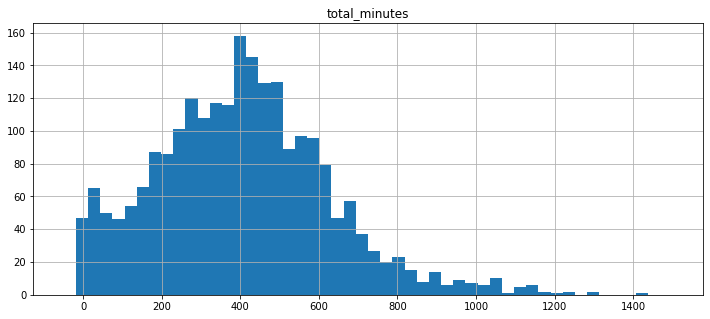

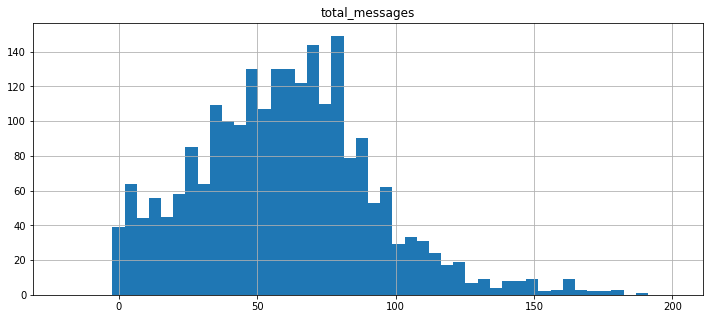

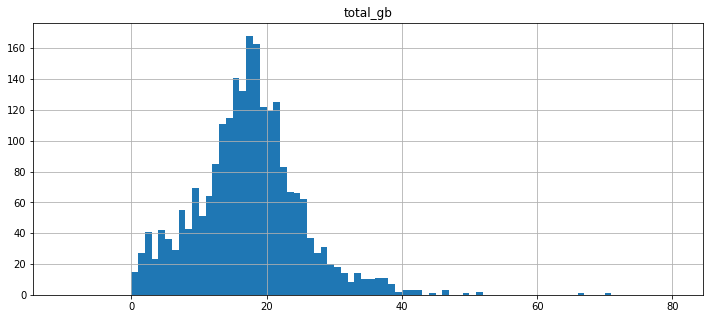

In [36]:
df.hist("total_minutes", figsize=(12, 5), range=(-50, 1500), bins=50)
plt.show()
df.hist("total_messages", figsize=(12, 5), range=(-20, 200), bins=50)
plt.show()
df.hist("total_gb", figsize=(12, 5), range=(-10, 80), bins=90)
plt.show()

Lo primero que podemos ver es que en cuanto a los valores de minutos y mensajes, tenemos un claro sesgo a la derecha o asimetría positiva. También lo vemos en los GB totales, pero no es tan marcado. A primera vista, lo que causa este sesgo son valores atípicos que extienden el rango del eje horizontal.

# 5.2 Valosres atípicos

Calculemos si hay valores atípicos usando el rango intercuartílico y diagramas de cajas

First quartile: 249.47499999999997
Third quartile: 540.4675
IQR: 290.9925
Límite inferior: -187.01375000000002
Límite superior: 976.95625


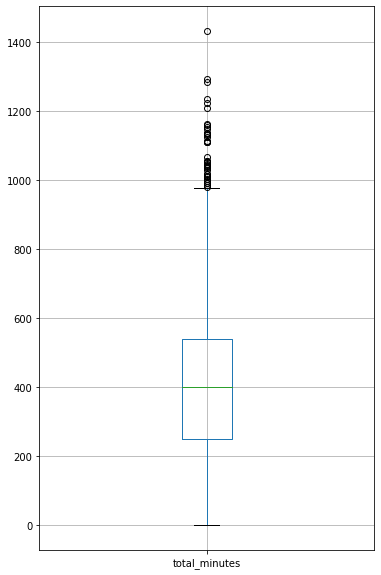

In [37]:
df.boxplot(column='total_minutes', figsize=(6, 10))
Q1 = df['total_minutes'].quantile(0.25)
Q3 = df['total_minutes'].quantile(0.75)
IQR = Q3 - Q1
print("First quartile:", Q1)
print("Third quartile:", Q3)
print("IQR:", IQR)
print("Límite inferior:", Q1 - 1.5 * IQR)
print("Límite superior:", Q3 + 1.5 * IQR)

First quartile: 38.0
Third quartile: 79.0
IQR: 41.0
Límite inferior: -23.5
Límite superior: 140.5


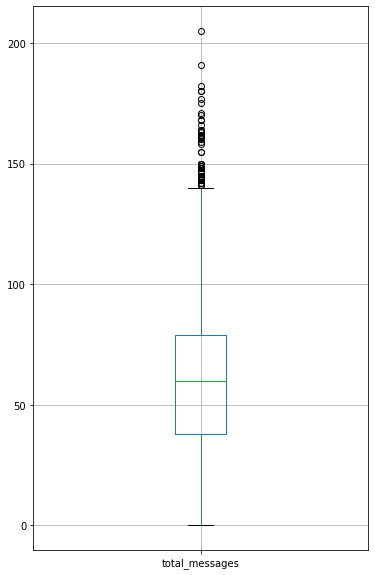

In [38]:
df.boxplot(column='total_messages', figsize=(6, 10))
Q1 = df['total_messages'].quantile(0.25)
Q3 = df['total_messages'].quantile(0.75)
IQR = Q3 - Q1
print("First quartile:", Q1)
print("Third quartile:", Q3)
print("IQR:", IQR)
print("Límite inferior:", Q1 - 1.5 * IQR)
print("Límite superior:", Q3 + 1.5 * IQR)

First quartile: 12.0
Third quartile: 21.0
IQR: 9.0
Límite inferior: -1.5
Límite superior: 34.5


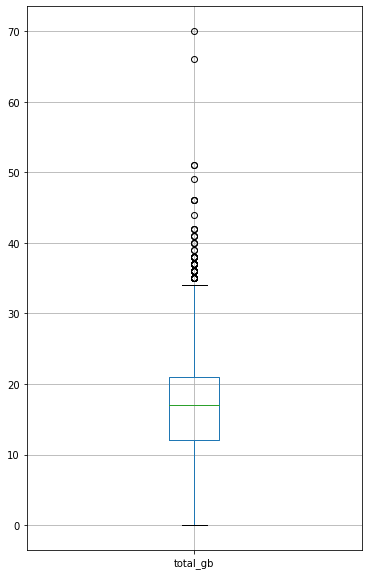

In [39]:
df.boxplot(column='total_gb', figsize=(6, 10))
Q1 = df['total_gb'].quantile(0.25)
Q3 = df['total_gb'].quantile(0.75)
IQR = Q3 - Q1
print("First quartile:", Q1)
print("Third quartile:", Q3)
print("IQR:", IQR)
print("Límite inferior:", Q1 - 1.5 * IQR)
print("Límite superior:", Q3 + 1.5 * IQR)

Podemos ver que, efectivamente, hay valores atípicos en los datos. En este estudio, no vamos a eliminar los valores que se salen del rango intercuartílico, ya que , si bien son valores atípicos, vamos a estudiarlos para tratar de entender cuáles son los requerimientos de los usuarios que exceden la capacidad de sus planes contratados. Para ello, haremos DataFrames filtrados para cada plan, y, en ellos, analizaremos los valores atípicos, especificamente aquellos que excedan los límites de cada plan.

# 5.3 Encontrando minutos, SMS y volumen de datos para cada tarifa por mes

Comencemos haciendo un data frame para los usuarios del plan surf y otro para los del plan ultimate

In [40]:
df_surf = df.query('plan != "ultimate"')
df_ultimate = df.query('plan != "surf"')

In [41]:
df_surf.describe()

,total_minutes,total_messages,total_gb,age,minutes_extra,messages_extra,gb_extra,total_income
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,404.762390,59.811825,16.670693,44.379530,48.823598,17.996821,3.865226,60.414772
std,221.664397,32.017989,7.847522,16.646535,110.068281,23.116573,5.445627,55.417998
min,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,20.000000
25%,255.470000,39.000000,12.000000,29.000000,0.000000,0.000000,0.000000,20.000000
50%,401.760000,60.000000,17.000000,45.000000,0.000000,10.000000,2.000000,40.000000
75%,543.680000,79.000000,21.000000,59.000000,43.680000,29.000000,6.000000,80.000000
max,1431.220000,205.000000,70.000000,75.000000,931.220000,155.000000,55.000000,589.177200


In [42]:
df_ultimate.describe()

,total_minutes,total_messages,total_gb,age,minutes_extra,messages_extra,gb_extra,total_income
count,719.000000,719.000000,719.000000,719.000000,719.0,719.0,719.000000,719.000000
mean,406.758025,60.710709,17.331015,47.688456,0.0,0.0,0.331015,72.317107
std,226.898171,33.188997,7.648185,16.795187,0.0,0.0,1.628959,11.402713
min,0.000000,0.000000,1.000000,18.000000,0.0,0.0,0.000000,70.000000
25%,246.680000,36.000000,13.000000,34.000000,0.0,0.0,0.000000,70.000000
50%,398.600000,61.000000,17.000000,48.000000,0.0,0.0,0.000000,70.000000
75%,532.665000,80.000000,21.000000,64.000000,0.0,0.0,0.000000,70.000000
max,1292.090000,191.000000,46.000000,75.000000,0.0,0.0,16.000000,182.000000


Podemos ver que en tabla filtrada para el plan surf, todos los valores máximos superan los límites de todos las variables del plan (minutos, mensajes y gb). Por otro lado, en la tabla que contiene solo a los usuarios del plan ultimate, solo es superado el valor máximo del plan respecto a los GB.

Para poder determinar solo a los usuarios que exceden alguno de los límites en alguna de las variables de su plan, usaremos una tabla filtrada que solo contenga usuarios en los que total_income sea mayor al valor del plan.

Comencemos haciendo un histograma con el plan ultimate, y vamos a establecer el límite inferior del rango a gráficar para cada variable en la cantidad que tenemos en el plan para cada variable. En otras palabras, graficaremos solo la data de los usuarios que exceda los minutos, mensajes y gb que contiene el plan, para detectar así los ingresos adicionales a la tarifa base del plan por usuario.

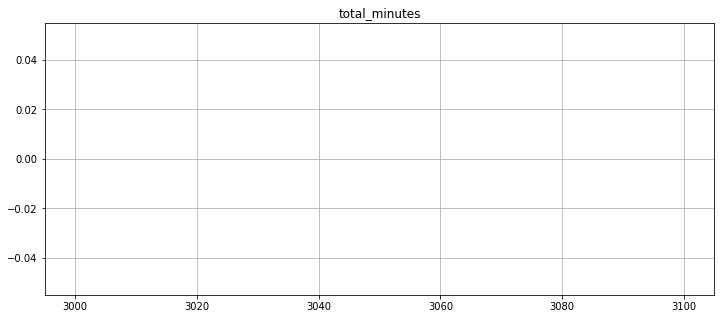

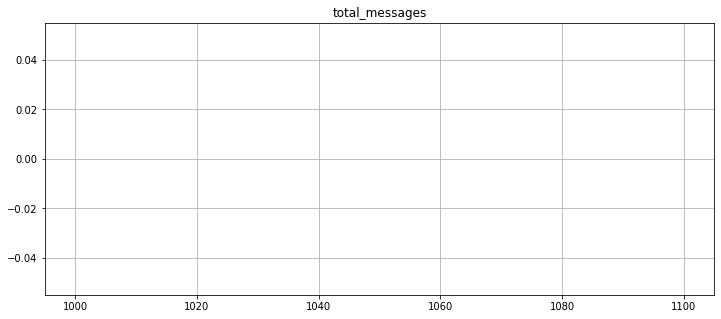

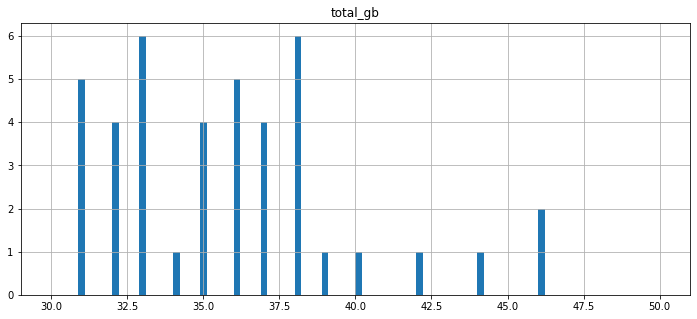

In [43]:
df_ultimate.query('total_income > 70').hist("total_minutes", figsize=(12, 5), range=(3000, 3100), bins=50)
plt.show()
df_ultimate.query('total_income > 70').hist("total_messages", figsize=(12, 5), range=(1000, 1100), bins=50)
plt.show()
df_ultimate.query('total_income > 70').hist("total_gb", figsize=(12, 5), range=(30, 50), bins=90)
plt.show()

Efectivamente, algunos usuarios de este plan solo exceden su cuota mensual de GB. Los minutos y mensajes que incluye el plan son más que necesarios ya que ni uno solo de sus usuarios los excede. Veamos el detalle de los usuarios que consumen más de la cantidad mensual de GB.

In [44]:
df_ult_gb = df_ultimate.query('total_income > 70 and total_gb > 30')
df_ult_gb['total_income'].groupby('user_id').unique()

user_id
1006                                              [84.0]
1028    [112.0, 119.0, 91.0, 126.0, 140.0, 182.0, 154.0]
1038                                      [126.0, 168.0]
1043                           [84.0, 77.0, 91.0, 126.0]
1057                                             [105.0]
1126                                              [98.0]
1144                         [126.0, 112.0, 119.0, 91.0]
1185                                              [84.0]
1196                                              [77.0]
1204                                             [112.0]
1246                                              [77.0]
1283                                              [91.0]
1301                                             [105.0]
1373                                       [84.0, 112.0]
1403                                       [105.0, 77.0]
1435                                              [91.0]
1460                                 [91.0, 105.0, 77.0]
1490                   

In [45]:
df_ultimate_income = df_ultimate.query('total_income > 70')
df_ultimate_income['total_income'].groupby('user_id').unique()

user_id
1006                                              [84.0]
1028    [112.0, 119.0, 91.0, 126.0, 140.0, 182.0, 154.0]
1038                                      [126.0, 168.0]
1043                           [84.0, 77.0, 91.0, 126.0]
1057                                             [105.0]
1126                                              [98.0]
1144                         [126.0, 112.0, 119.0, 91.0]
1185                                              [84.0]
1196                                              [77.0]
1204                                             [112.0]
1246                                              [77.0]
1283                                              [91.0]
1301                                             [105.0]
1373                                       [84.0, 112.0]
1403                                       [105.0, 77.0]
1435                                              [91.0]
1460                                 [91.0, 105.0, 77.0]
1490                   

Vemos que, si hacemos una tabla con todos los ingresos adicionales del plan ultimate, es exactamente igual a la tabla df_ult_gb, ya que solo hay ingresos adicionales en el consuo de GB. Hay un total de 18 clientes que excenden la cantidad de GB al mes que incluye el plan, y, de esos, 8 lo hacen durante varios meses.

En ese sentido, lo que podemos decir acerca de los usuarios del plan ultimate, es que los minutos que incluye el mismo son más que suficientes, al igual que los SMS. Sin embargo, especto al consumo de datos que requieren, pareciera que algunos usuarios se quedan cortos con lo que el plan les ofrece. Veamos que proporción del total representan.

In [46]:
gb_outliners = 17 / len(df_ultimate)

f"El porcentaje de usuarios que execede los GB incluidos en el plan ultimate es: {gb_outliners:.0%}"

'El porcentaje de usuarios que execede los GB incluidos en el plan ultimate es: 2%'

Repitamos el análisis ahora con los usuarios del plan surf, graficando también solo la data de los usuarios que exceda los minutos, mensajes y GB que contiene el plan

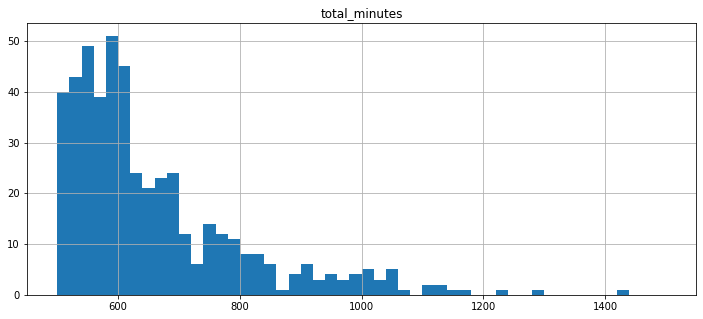

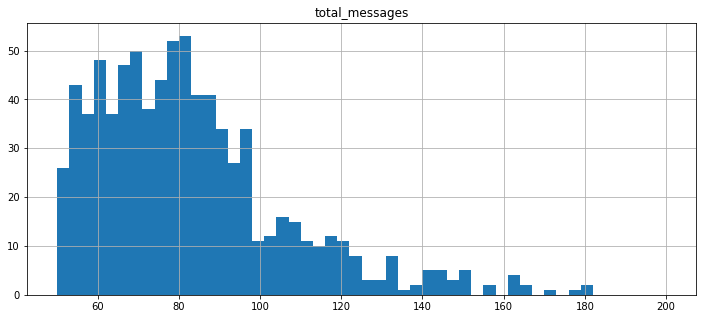

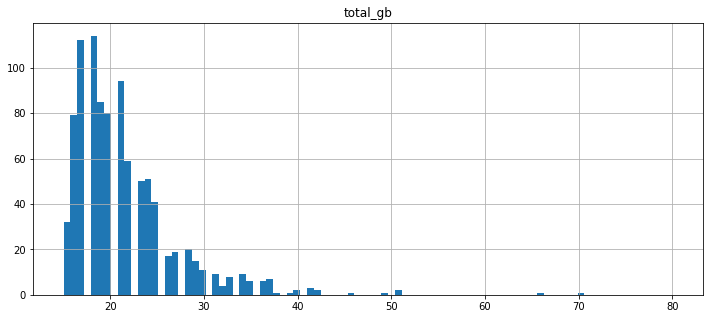

In [47]:
df_surf.query('total_income > 20').hist("total_minutes", figsize=(12, 5), range=(500, 1500), bins=50)
plt.show()
df_surf.query('total_income > 20').hist("total_messages", figsize=(12, 5), range=(50, 200), bins=50)
plt.show()
df_surf.query('total_income > 20').hist("total_gb", figsize=(12, 5), range=(15, 80), bins=90)
plt.show()

Aquí cambia bastante el resultado. Vemos que muchos usuarios consumen más de todas las variables que incluye el plan. Revisemos con detalle minutos, mensajes y GB.

In [48]:
df_surf_min = df_surf.query('total_income > 20 and total_minutes > 500')
df_surf_min['total_minutes'].groupby('user_id').unique()

user_id
1003                                 [1040.9999999999998]
1007                          [610.65, 579.4300000000001]
1009    [775.5200000000003, 826.7400000000001, 680.39,...
1010    [618.43, 524.1400000000003, 658.2399999999999,...
1014                                 [1050.6199999999997]
                              ...                        
1483                                  [639.0000000000001]
1488    [669.4500000000002, 589.7299999999999, 642.25,...
1491                                  [551.8899999999998]
1494                                  [585.8199999999999]
1495                                  [578.0299999999997]
Name: total_minutes, Length: 161, dtype: object

In [49]:
df_surf_sms = df_surf.query('total_income > 20 and total_messages > 50')
df_surf_sms['total_messages'].groupby('user_id').unique()

user_id
1001          [65.0, 64.0, 56.0]
1002                      [55.0]
1003                     [149.0]
1004                      [54.0]
1005                      [59.0]
                  ...           
1491                      [75.0]
1494          [78.0, 67.0, 82.0]
1495    [52.0, 75.0, 61.0, 65.0]
1496                      [52.0]
1499                [53.0, 65.0]
Name: total_messages, Length: 232, dtype: object

In [50]:
df_surf_gb = df_surf.query('total_income > 20 and total_gb > 15')
df_surf_gb['total_gb'].groupby('user_id').unique()

user_id
1001                            [22.0, 19.0]
1002                                  [19.0]
1003                                  [27.0]
1004          [21.0, 24.0, 28.0, 19.0, 22.0]
1005                                  [17.0]
                        ...                 
1494                      [17.0, 16.0, 18.0]
1495                [23.0, 27.0, 25.0, 24.0]
1496                                  [17.0]
1498    [20.0, 22.0, 25.0, 23.0, 21.0, 19.0]
1499                      [20.0, 17.0, 22.0]
Name: total_gb, Length: 261, dtype: object

Veamos en total cuántos usuarios exceden al menos uno de los beneficios de su plan.

In [51]:
df_surf_income = df_surf.query('total_income > 20')
df_surf_income['total_income'].groupby('user_id').unique()

user_id
1001                                 [90.0, 60.0]
1002                                       [60.0]
1003                                      [159.2]
1004             [80.0, 110.0, 150.0, 60.0, 90.0]
1005                                       [40.0]
                          ...                    
1494       [40.0, 30.0, 22.574599999999997, 50.0]
1495    [100.0, 143.09089999999998, 120.0, 110.0]
1496                                       [40.0]
1498       [70.0, 90.0, 120.0, 100.0, 80.0, 60.0]
1499                           [70.0, 40.0, 90.0]
Name: total_income, Length: 284, dtype: object

In [52]:
surf_outliners = 277 / len(df_surf)
f"El porcentaje de usuarios que execede los minutos, mensajes o GB incluidos en el plan surf es: {surf_outliners:.0%}"

'El porcentaje de usuarios que execede los minutos, mensajes o GB incluidos en el plan surf es: 18%'

Por último, veamos como fue el comportamiento en cuanto al consumo de minutos, mensajes y datos para cada plan a lo largo de los meses del año

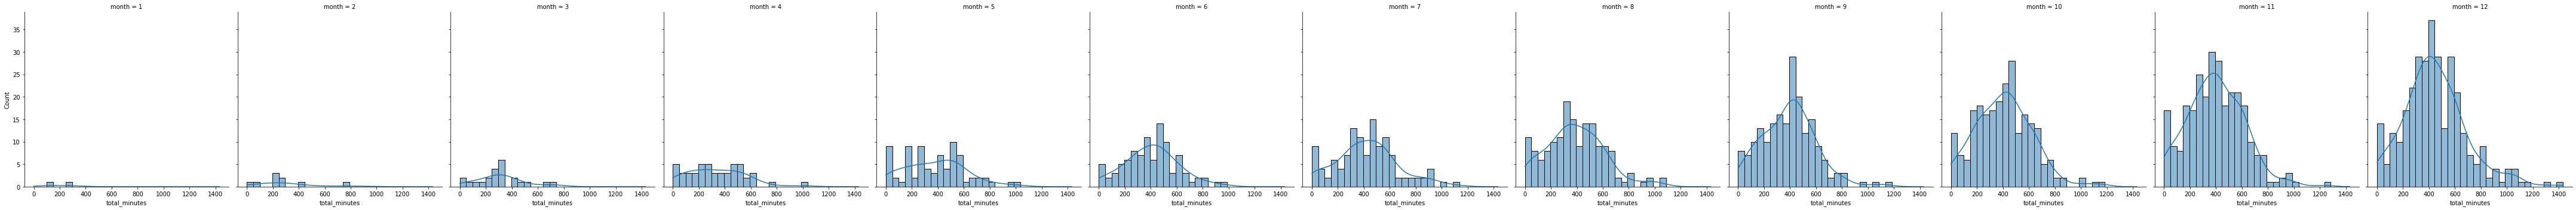

In [53]:
sns.displot(data=df_surf, x='total_minutes', col='month', kde=True)

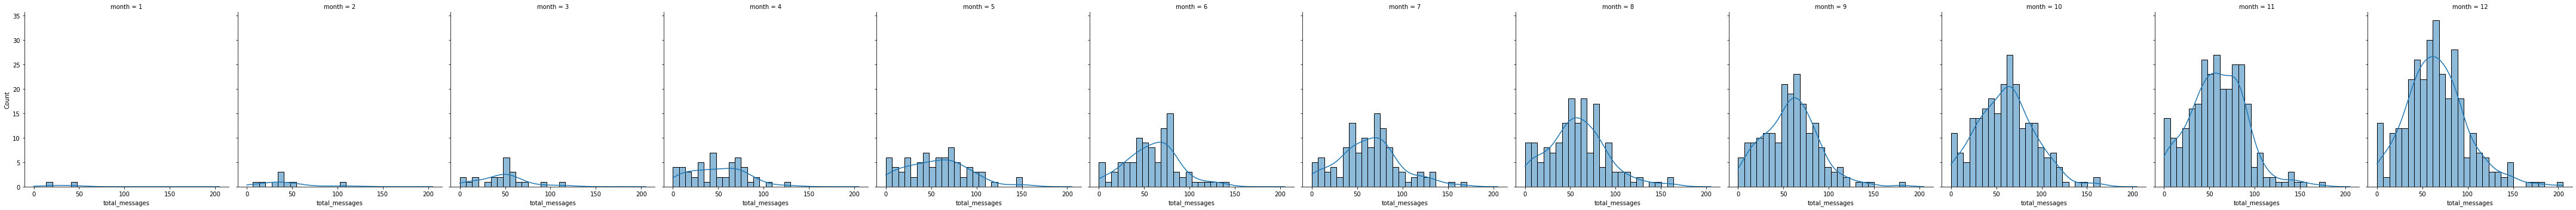

In [54]:
sns.displot(data=df_surf, x='total_messages', col='month', kde=True)

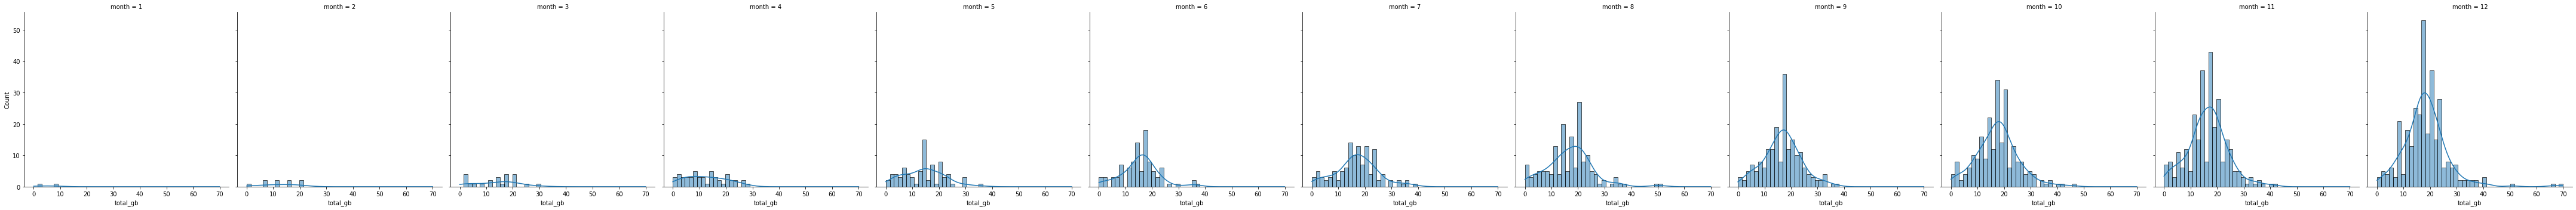

In [55]:
sns.displot(data=df_surf, x='total_gb', col='month', kde=True)

Vemos que en el plan surf, en todas las variables el consumo medio se va incrementando a medida que avanza el año

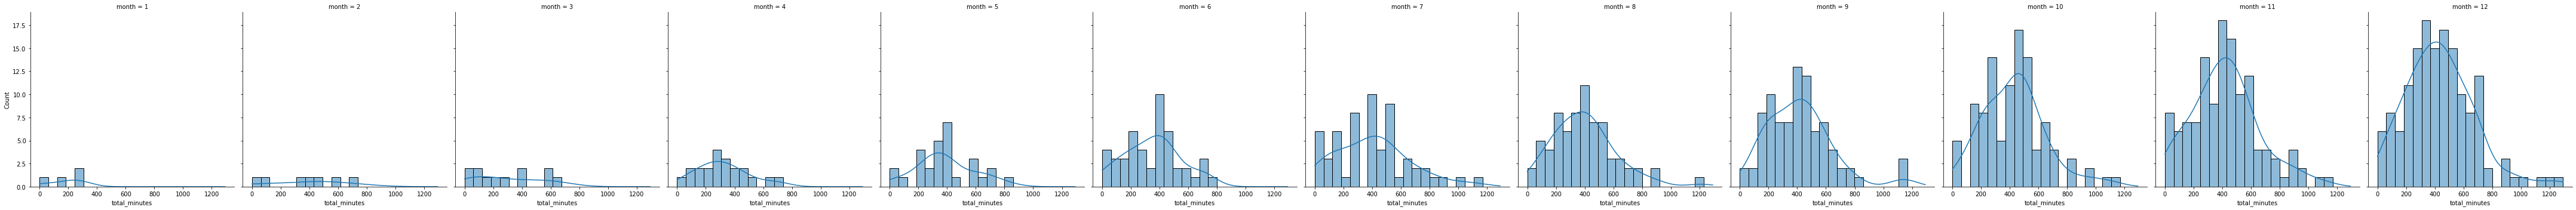

In [56]:
sns.displot(data=df_ultimate, x='total_minutes', col='month', kde=True)

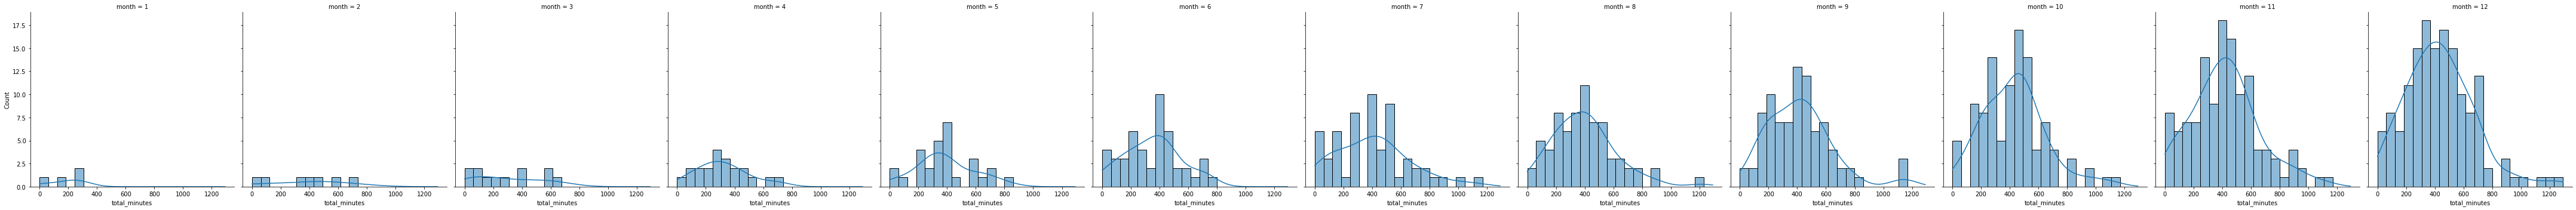

In [57]:
sns.displot(data=df_ultimate, x='total_minutes', col='month', kde=True)

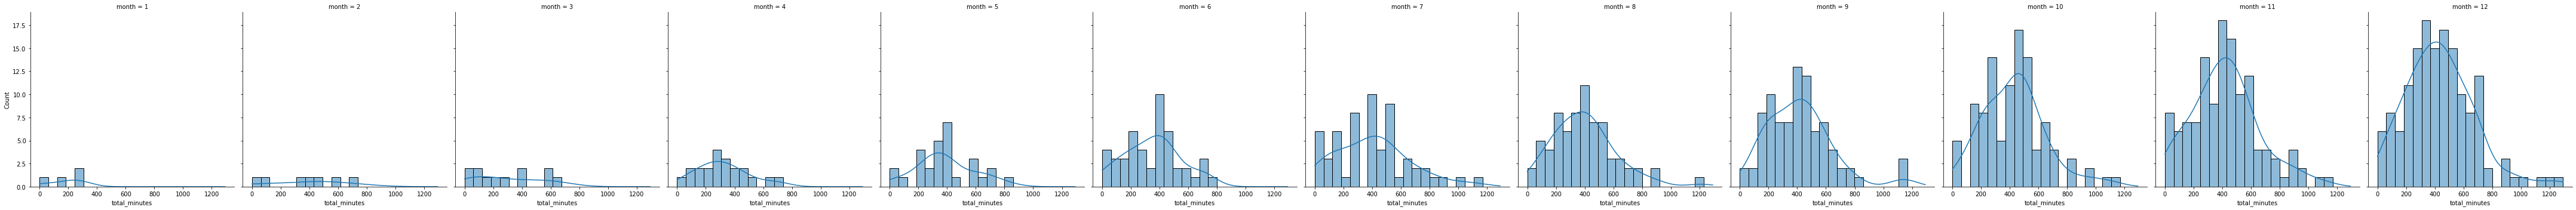

In [58]:
sns.displot(data=df_ultimate, x='total_minutes', col='month', kde=True)

Vemos que en el plan ultimate se repite el comportamiento, en todas las variables el consumo medio se va incrementando a medida que avanza el año.

Vamos a determinar qué tarifa de prepago genera más ingresos. Primero, vamos a determinar la cantidad de usuarios que tiene cada plan en la uestra seleccionada

In [59]:
len(users.query('plan == "ultimate"'))

161

In [60]:
len(users.query('plan == "surf"'))

339

Ahora, calculemos los ingresos generados por cada cliente sumando el total de la columna total income, que, como recordamos, incluye la tarifa base del plan más el consumo adicional en caso de que exista.

In [61]:
surf_total_income = df_surf['total_income'].sum()
print(f'En la muestra seleccionada, el plan surf genera un total de ingresos de: {surf_total_income}')
ultimate_total_income = df_ultimate['total_income'].sum()
print(f'En la muestra seleccionada, el plan ultimate genera un total de ingresos de: {ultimate_total_income}')

En la muestra seleccionada, el plan surf genera un total de ingresos de: 95032.4356
En la muestra seleccionada, el plan ultimate genera un total de ingresos de: 51996.0


Vemos que el plan surf genera casi el doble de ingresos totales que el plan últimate.

Ahora, calcularemos la media, la desviación estándar y la varianza. las dos primeras, podemos obtenerlas con el método describe

In [62]:
df_surf.describe()

,total_minutes,total_messages,total_gb,age,minutes_extra,messages_extra,gb_extra,total_income
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,404.762390,59.811825,16.670693,44.379530,48.823598,17.996821,3.865226,60.414772
std,221.664397,32.017989,7.847522,16.646535,110.068281,23.116573,5.445627,55.417998
min,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,20.000000
25%,255.470000,39.000000,12.000000,29.000000,0.000000,0.000000,0.000000,20.000000
50%,401.760000,60.000000,17.000000,45.000000,0.000000,10.000000,2.000000,40.000000
75%,543.680000,79.000000,21.000000,59.000000,43.680000,29.000000,6.000000,80.000000
max,1431.220000,205.000000,70.000000,75.000000,931.220000,155.000000,55.000000,589.177200


In [63]:
df_ultimate.describe()

,total_minutes,total_messages,total_gb,age,minutes_extra,messages_extra,gb_extra,total_income
count,719.000000,719.000000,719.000000,719.000000,719.0,719.0,719.000000,719.000000
mean,406.758025,60.710709,17.331015,47.688456,0.0,0.0,0.331015,72.317107
std,226.898171,33.188997,7.648185,16.795187,0.0,0.0,1.628959,11.402713
min,0.000000,0.000000,1.000000,18.000000,0.0,0.0,0.000000,70.000000
25%,246.680000,36.000000,13.000000,34.000000,0.0,0.0,0.000000,70.000000
50%,398.600000,61.000000,17.000000,48.000000,0.0,0.0,0.000000,70.000000
75%,532.665000,80.000000,21.000000,64.000000,0.0,0.0,0.000000,70.000000
max,1292.090000,191.000000,46.000000,75.000000,0.0,0.0,16.000000,182.000000


Para obtener la varianza, utilizaremos el método var de numpy

In [64]:
surf_var = np.var(df_surf)
surf_var

total_minutes     49103.868333
total_messages     1024.499873
total_gb             61.544449
age                 276.930973
minutes_extra     12107.324559
messages_extra      534.036226
gb_extra             29.636000
total_income       3069.202124
dtype: float64

In [65]:
ultimate_var = np.var(df_ultimate)
ultimate_var

total_minutes     51411.176831
total_messages     1099.977507
total_gb             58.413377
age                 281.685972
minutes_extra         0.000000
messages_extra        0.000000
gb_extra              2.649817
total_income        129.841029
dtype: float64

# 5.4 Conclusiones

En el plan ultimate podemos ver que solo el 2% de todos los usuarios del plan se quedan cortos con la cantidad de GB al mes que este les ofrece. Estos usuarios requieren un mayor volumen de datos al mes. Respecto a los minutos y mensajes, el plan si cubre los requerimientos de los clientes.

En el plan surf, vemos que el 17% del total de usuarios, adicional a la tarifa del plan, deben pagar un monto extra por consumo adicional de minutos, mensajes y GB. Cuando lo vemos en dinero, muchos de estos usuarios pagan incluso más de lo que pagarían por el plan ultimate, que incluye muchos más minutos mensajes y GB. Estos usuarios tienen un mayor requirimiento de minutos, mensajes y GB, por lo que sería una buena idea cambiarse al plan ultimate.

También es importante destacar que, en la muestra seleccionada, hay una mayor cantidad de clientes que usan el plan surf, más del doble de los que usan el plan últimate.

[Volver a Contenidos](#back)

# Etapa 6. Prueba de hipótesis
Probaremos dos hipótesis:
- El ingreso adicional promedio de los usuarios de las tarifas Ultimate y Surf difiere.
- El ingreso adicional promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

## Hipótesis 1.

La hipótesis nula es que el ingreso promedio de los usuarios de las tarifas ultimate y surf no son iguales. Por lo tanto, la hipótesis alternativa es que el ingreso promedio de los usuarios de las tarifas ultimate y surf es igual.

Formulamos la hipótesis nula y alternativa estructurándolas como hipótesis sobre la igualdad de las medias de dos poblaciones, ya que lo que buscamos hacer es comparar las medias de dos poblaciones estadísticas diferentes. Lo que buscamos estudiar es si la diferencia entre las medias es significativa o no, para decidir si rechazar o no la hipótesis nula.

Utilizaremos el método scipy.stats.ttest_ind(array1, array2, equal_var), estableciendo el parámetro equal_var en False, ya que las varianzas de las tablas no son iguales.

$$H_0:\mu_{ult}=\mu_{surf}$$
$$H_1:\mu_{ult}\neq\mu_{surf}$$

In [66]:
surf_income = df_surf['total_income']
ultimate_income = df_ultimate['total_income']

print('Ingresos medios del plan surf:', pd.Series(surf_income).mean())
print('Ingresos medios del plan ultimate:', pd.Series(ultimate_income).mean())

alpha = 0.05

results = st.ttest_ind(surf_income, ultimate_income, equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

Ingresos medios del plan surf: 60.4147715193897
Ingresos medios del plan ultimate: 72.31710709318497
p-value: 6.693527092510372e-16
Rechazamos la hipótesis nula


Vemos en el resultado de la prueba de hipótesis que el p-value es menor que alpha, por lo que rechazamos la hipótesis nula. Podemos concluir que los ingresos medios de cada plan no son iguales.

## Hipótesis 2.

En la segúnda hipótesis, queremos ver si el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones. La hipótesis nula es que el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey y el de los usuarios de otras regiones son iguales. Por lo tanto, la hipótesis alternativa es que el ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey y el de los usuarios de otras regiones no es igual.

Al igual que en la hipótesis anterior, esta segunda hipótesis nula y alternativa son hipótesis sobre la igualdad de las medias de dos poblaciones,ya que también buscamos estudiar es si la diferencia entre las medias de cada región es significativa o no, para decidir si rechazar o no la hipótesis nula.

Utilizaremos de nuevo el método scipy.stats.ttest_ind(array1, array2, equal_var), estableciendo el parámetro equal_var en False, ya que las varianzas de las tablas no son iguales.

In [67]:
# El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

df_ny_nj_income = df.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA" and total_income > 0')
df_others_income = df.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA" and total_income > 0')

ny_nj_income = df_ny_nj_income['total_income']
others_income = df_others_income['total_income']

print('Ingresos medios adicionales el área de estados Nueva York-Nueva Jersey:', pd.Series(ny_nj_income).mean())
print('Ingresos medios adicionales otras regiones:', pd.Series(others_income).mean())

alpha = 0.05

results = st.ttest_ind(ny_nj_income, others_income, equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

Ingresos medios adicionales el área de estados Nueva York-Nueva Jersey: 59.742751063829786
Ingresos medios adicionales otras regiones: 65.01313215031315
p-value: 0.035071202577512055
Rechazamos la hipótesis nula


Observamos que el p-valor es menor a alpha, por lo que rechazamos la hipótesis nula. Podemos concluir que los ingresos medios de cada región no son iguales.

[Volver a Contenidos](#back)

# Etapa 7. Conclusión General

Según el estudio realizado, podemos concluir:
- Un porcentaje importante de los usuarios del plan surf tienen requerimientos mayores de minutos, mensajes y datos
- Un porcentaje menor de los usuarios del plan ultimate tienen requerimientos mayores de datos
- Los ingresos adicionales promedio de los planes surf y últimate difieren pero en una proporción no significativa
- Los ingresos adicionales promedio del área de Nueva York y Nueva Jersey difieren de los de el resto de las regiones pero en una proporción no significativa
- El consumo de minutos, mensajes y datos tiene una clara tendencia al alza
- Hay más usuarios del plan surf que del plan ultimate

Una de las intenciones de este estudio, es determinar cuál de los planes genera más ingresos para que el departamento comercial pueda ajustar su presupuesto de publicidad. En ese setido, el plan surf genera mayores ingresos totales, pero el plan ultimate genera ingresos promedio mayores gracias a su tarifa base más alta. En vista de la información analizada, hacemos las siguientes sugerencias, considerando ofrecer una mejor experiencia de usuario y atraer nuevos clientes:

- Promocionar más el plan ultimate, para atraer nueva clientela, ya que es el plan que, en promedio, genera mayores ingresos.
- Proponemos ofrecer a los usuarios del plan surf que exceden mensualmente su cupo de minutos, mensajes y datos cambiarse al plan ultimate, ya que de esa forma no necesitarán hacer pagos adicionales por el exceso de consumo.
- De igual forma, y en vista de que pudimos apreciar en nuestra muestra una clara tendencia al alza en el consumo de minutos, mensajes y datos, proponemos crear nuevos planes que se adapten a los requerimientos de los clientes. Aquí algunos ejemplos:
    - Un plan con más GB
    - Un plan con la opción de navegación por internet o redes sociales ilimitadas.
    - Un plan con minutos ilimitados.
    - Un plan con minutos y datos ilimitados.
    
Esperamos que los resultados obtenidos sean de utilidad para mejorar tanto las ventas como el servicio y la experiencia del cliente